DATA SET LINK - https://www.kaggle.com/datasets/iarunava/cell-images-for-detecting-malaria

* IMPORT ALL MODULES REQUIRED FOR PROJECT.





In [1]:
!pip install alive-progress

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.6/70.6 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 11.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 4.5 MB/s eta 0:00:00
  Created wheel for grapheme: filename=grapheme-0.6.0-py3-none-any.whl size=210082 sha256=1cb20c3b7e542015920ecc35e9109249e5160993039f8b30cc01f0100386e4ce
  Stored in directory: /root/.cache/pip/wheels/01/e1/49/37e6bde9886439057450c494a79b0bef8bbe897a54aebfc757
Successfully built grapheme


In [2]:
!chmod 600 kaggle.json

In [3]:
!pip install kaggle

In [12]:
!kaggle datasets download -d "iarunava/cell-images-for-detecting-malaria"

Dataset URL: https://www.kaggle.com/datasets/iarunava/cell-images-for-detecting-malaria
License(s): unknown
 99% 667M/675M [00:08<00:00, 277MB/s]
100% 675M/675M [00:08<00:00, 82.4MB/s]


In [6]:
import glob
import matplotlib.pyplot as plt
from skimage import io
from skimage import filters
import csv
from skimage.color import rgb2gray
from skimage.util import img_as_ubyte
import cv2
from google.colab.patches import cv2_imshow
from google.colab import files
import os
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from alive_progress import alive_bar

*   READ IMAGES FROM GOOGLE DRIVE STORAGE AND PROCESS USING SKIMAGE AND OPENCV






In [14]:
!unzip cell-images-for-detecting-malaria.zip

Streaming output truncated to the last 5000 lines.
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_118.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_126.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_134.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_141.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_168.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_175.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_183.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_221.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_222.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_87.png  
  inflating: cell_im

In [18]:
dataset_path = './cell_images/'

In [16]:
#Set google drive paths to read images in loop and create list of the paths to iterate in for loop.
path_infected = os.path.join(dataset_path, 'Parasitized')
path_uninfected = os.path.join(dataset_path, 'Uninfected')
directory=[path_infected,path_uninfected]

#creating .csv file based on results obtained by image processing.
rows=[]
for path in directory:

  len_images = len(os.listdir(path))
  with alive_bar(len_images) as bar:
    for image in os.scandir(path):
      # if count>50: #stop iterating images at value when dataset size reaches size n
      #   break
      if (image.path.endswith(".png")): #perform image processing operations only if file is a .PNG image.
        im = io.imread(image.path)
        im = filters.gaussian(im,sigma=0.9)
        im_gray = rgb2gray(im)
        im_gray=img_as_ubyte(im_gray) #change image encoding to allow further processing using openCV

        #process image using opencv to find contours.
        ret,thresh = cv2.threshold(im_gray,127,255,0)
        contours,_ = cv2.findContours(thresh,1,2)
        cv2.drawContours(im,contours, -1, (0, 255, 0), 3)
        # cv2_imshow(im)
        data=[]

        for i in range (5): #run for loop to get area of contours and setting status.
          if i<len(contours):
            data.append(str(cv2.contourArea(contours[i])))
          else:
            data.append("0")
        if path==path_infected:
          data.append("infected")
        else:
          data.append("uninfected")
        rows.append(data)
        bar()

#write the csv file from processed data.
fields = ['Area-1', 'Area-2', 'Area-3','Area-4','Area-5',"Status"]
with open('dataset-single.csv', 'w') as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(fields)
    csvwriter.writerows(rows)

|████████████████████████████████████████⚠︎ (!) 13779/13780 [100%] in 57.7s (238.80/s) 
|████████████████████████████████████████⚠︎ (!) 13779/13780 [100%] in 53.9s (255.43/s) 


*  READ CSV,SAVE TO PANDAS DATA FRAME AND CREATE MULTIPLE ML MODELS




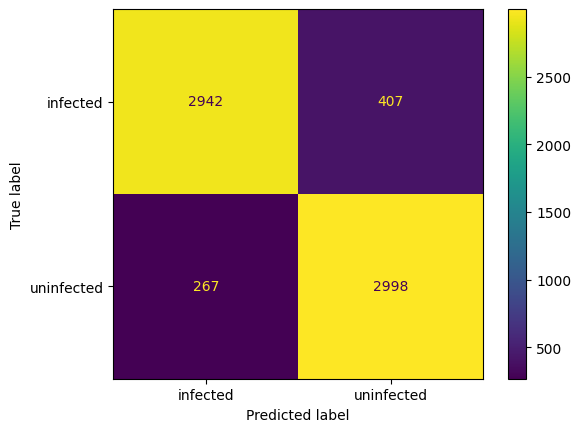

Accuracy score on test dataset ( KNeighborsClassifier ):  0.8980949501058361





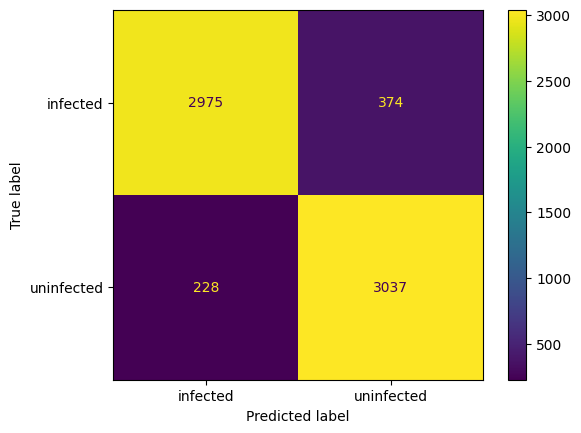

Accuracy score on test dataset ( DecisionTreeClassifier ):  0.9089809495010583





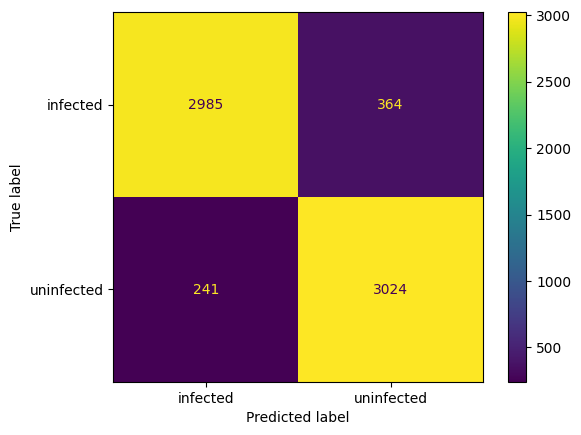

Accuracy score on test dataset ( RandomForestClassifier ):  0.9085273661929241





In [22]:
# read the train and test dataset
data = pd.read_csv('dataset-single.csv')

# Now, we need to predict the missing target variable in the test data
# target variable - infected/uninfected
X = data.iloc[:, :-1]
y = data.iloc[:, -1]
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size = 0.24, random_state = 42)
model = [KNeighborsClassifier(), DecisionTreeClassifier(max_depth=5), RandomForestClassifier(max_depth=5, n_estimators=5, max_features=1)]
model_names= ["KNeighborsClassifier", "DecisionTreeClassifier", "RandomForestClassifier"]
accuracy_test=[]
for i in range(len(model)):
  # fit the model with the training data
  model[i].fit(train_X,train_y)

  # predict the target on the test dataset
  predict_test = model[i].predict(test_X)

  # plot confusion matrix for each of the models
  cm_display = ConfusionMatrixDisplay.from_estimator(model[i], test_X, test_y)
  plt.show()

  # Accuracy Score on test dataset
  accuracy_test.append(accuracy_score(test_y,predict_test))
  print('Accuracy score on test dataset (',model_names[i],"): ",accuracy_test[i], end="\n\n\n\n")

*   UPLOAD IMAGE TO CLASSIFY WHETHER IMAGE IS INFECTED OR NOT


In [ ]:

uploaded = files.upload()
filename=list(uploaded.keys())
print("\n")
if filename[0].endswith(".png"):
  im = io.imread(filename[0])
  im = filters.gaussian(im,sigma=0.8,multichannel=False)
  im_gray = rgb2gray(im)
  im_gray=img_as_ubyte(im_gray)

  ret,thresh = cv2.threshold(im_gray,127,255,0)
  contours,_ = cv2.findContours(thresh,1,2)
  cv2.drawContours(im,contours, -1, (0, 255, 0), 3)
  data=[]
  for i in range (5):
    if i<len(contours):
      data.append(float(cv2.contourArea(contours[i])))
    else:
      data.append(0.0)
  sample_test=[data]

  for i in range(len(model)):
    predict_sample = model[i].predict(sample_test)
    print("Result: ",predict_sample[0],"\nAccuracy of Model: (",model_names[i],"): ",accuracy_test[i],"\n")
else:
  print("Upload .PNG image file!")

In [ ]:
cm_display = ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test)
plt.show()

COMPLETE CODE

In [ ]:
import matplotlib.pyplot as plt
from skimage import io
from skimage import filters
import csv
from skimage.color import rgb2gray
from skimage.util import img_as_ubyte
import cv2
from google.colab.patches import cv2_imshow
from google.colab import files
import os
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

dataset_path = './cell_images/'
path_infected=os.path.join(dataset_path, 'Parasitized')
path_uninfected=os.path.join(dataset_path, 'Uninfected')
directory=[path_infected,path_uninfected]
rows=[]
for path in directory:
  count=0
  for image in os.scandir(path):
    count=count+1
    if count>1000:
      break
    if (image.path.endswith(".png")):
      im = io.imread(image.path)
      im = filters.gaussian(im,sigma=0.9,multichannel="False")
      im_gray = rgb2gray(im)
      im_gray=img_as_ubyte(im_gray)

      ret,thresh = cv2.threshold(im_gray,127,255,0)
      contours,_ = cv2.findContours(thresh,1,2)
      cv2.drawContours(im,contours, -1, (0, 255, 0), 3)
      data=[]

      for i in range (5):
        if i<len(contours):
          data.append(str(cv2.contourArea(contours[i])))
        else:
          data.append("0")
      if path==path_infected:
        data.append("infected")
      else:
        data.append("uninfected")
      rows.append(data)

fields = ['Area-1', 'Area-2', 'Area-3','Area-4','Area-5',"Status"]
with open('dataset-tp.csv', 'w') as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(fields)
    csvwriter.writerows(rows)

ret,thresh = cv2.threshold(im_gray,127,255,0)
contours,_ = cv2.findContours(thresh,1,2)
cv2.drawContours(im,contours, -1, (0, 255, 0), 3)
data = []
for i in range (5):
  if i<len(contours):
    data.append(str(cv2.contourArea(contours[i])))
  else:
    data.append("0")
rows.append(data)

dataset = pd.read_csv('dataset-1000.csv')

X = dataset.iloc[:, :-1]
y = dataset.iloc[:, -1]
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size = 0.3, random_state = 42)
model = [KNeighborsClassifier(5), DecisionTreeClassifier(max_depth=5), RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1)]
model_names= ["KNeighborsClassifier", "DecisionTreeClassifier", "RandomForestClassifier"]

accuracy_test = []
for i in range(len(model)):
  model[i].fit(train_X,train_y)
  predict_test = model[i].predict(test_X)
  accuracy_test.append(accuracy_score(test_y,predict_test))

uploaded = files.upload()
filename = list(uploaded.keys())
print("\n")
if filename[0].endswith(".png"):
  im = io.imread(filename[0])
  im = filters.gaussian(im,sigma=0.8,multichannel=False)
  im_gray = rgb2gray(im)
  im_gray=img_as_ubyte(im_gray)

  ret,thresh = cv2.threshold(im_gray,127,255,0)
  contours,_ = cv2.findContours(thresh,1,2)
  cv2.drawContours(im,contours, -1, (0, 255, 0), 3)
  data = []
  for i in range (5):
    if i<len(contours):
      data.append(float(cv2.contourArea(contours[i])))
    else:
      data.append(0.0)
  sample_test = [data]

  for i in range(len(model)):
    predict_sample = model[i].predict(sample_test)
    print("Result: ", predict_sample[0], "\nAccuracy of Model: (", model_names[i], "): ", round(accuracy_test[i],3), "\n")
else:
  print("Upload .PNG image file!")

In [ ]:
from telegram.ext import Updater, CommandHandler, MessageHandler, Filters

# Define a few command handlers. These usually take the two arguments update and
# context. Error handlers also receive the raised TelegramError object in error.
def start(update, context):
    update.message.reply_text('Hey! This is a bot to tell if your cell sample is detected with malaria or not. Upload an image of a Cell to Check!')

def check(update, context):
    update.message.reply_text('Bot is Working Fine! Tell this to Naman \U0001F923')

def malariapred(update, context):
  # try:
  obj=context.bot.getFile(file_id=update.message.document.file_id)
  print(obj)
  print(update)
  print(context)
  img=obj.download()
  print(str(img))
  im = io.imread(str(img))
  io.imshow(im)
  update.message.reply_text("File has been downloaded.")
  im = io.imread(str(img))
  io.imshow(im)
  im = filters.gaussian(im,sigma=0.8,multichannel=False)
  im_gray = rgb2gray(im)
  im_gray=img_as_ubyte(im_gray)

  ret,thresh = cv2.threshold(im_gray,127,255,0)
  contours,_ = cv2.findContours(thresh,1,2)
  cv2.drawContours(im,contours, -1, (0, 255, 0), 3)
  data = []
  for i in range (5):
    if i<len(contours):
      data.append(float(cv2.contourArea(contours[i])))
    else:
      data.append(0.0)
  sample_test = [data]

  for i in range(len(model)):
    predict_sample = model[i].predict(sample_test)
    update.message.reply_text("Result: " + str(predict_sample[0]) +"\nAccuracy of Model: ("+ model_names[i] + "): " + str(round(accuracy_test[i],3)) + "\n")
  # except Exception as e:
  #   print(str(e))



def main():
    """Start the bot."""
    # Create the Updater and pass it your bot's token.
    # Make sure to set use_context=True to use the new context based callbacks
    # Post version 12 this will no longer be necessary
    TOKEN="1727119674:AAEEMbRziRyZc3e2RSC4YG5B7LZ0m8bL1hw"
    updater = Updater(TOKEN, use_context=True)

    # Get the dispatcher to register handlers
    dp = updater.dispatcher

    # on different commands - answer in Telegram
    dp.add_handler(CommandHandler("start", start))
    dp.add_handler(CommandHandler("check", check))
    dp.add_handler(MessageHandler(Filters.document.image, malariapred))

    # on noncommand i.e message - echo the message on Telegram
    dp.add_handler(MessageHandler(Filters.text, start))

    # log all errors

    # Start the Bot
    updater.start_polling()
    updater.idle()


if __name__ == '__main__':
    main()